In [54]:
import pandas as pd
import os
import gc
import numpy as np
from tempfile import mkdtemp
import tensorflow as tf
import matplotlib.pyplot as plt

In [55]:
def plt_plot(y_real,y_predict):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(len(y_real)),y_real, color='r')
    ax.plot(range(len(y_predict)),y_predict, color='b')
    plt.show()

In [2]:
source_dire="feature"

In [3]:
df_train=pd.DataFrame([])
df_validation=pd.DataFrame([])
for i in range(1,6):    
    df_temp=pd.read_csv(os.path.join(source_dire,"test_"+str(i)+"_feature.csv"))
    df_validation=df_validation.append(df_temp)
for i in range(1,4):    
    df_temp=pd.read_csv(os.path.join(source_dire,"train_"+str(i)+"_feature.csv"))
    df_train=df_train.append(df_temp)
train_label=df_train["residual_life"].values.reshape(-1,60,1)
df_train.drop('residual_life',axis=1,inplace=True)
train_data=df_train.values.reshape(-1,60,52)

valid_label=df_validation["residual_life"].values.reshape(-1,60,1)
df_validation.drop('residual_life',axis=1,inplace=True)
valid_data=df_validation.values.reshape(-1,60,52)
gc.collect()
print(train_data.shape,train_label.shape,valid_data.shape,valid_label.shape)

(133, 60, 52) (133, 60, 1) (50, 60, 52) (50, 60, 1)


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras import models as M
from keras import layers as L
from keras import metrics
from keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [5]:
def evaluation_metric(y_true, y_pred):
    y_true, y_pred = tf.reshape(y_true, [-1]), tf.reshape(y_pred, [-1])
    er = y_true - y_pred
    mask_n, mask_p = (er<=0), (er>0)
    er_n, er_p = tf.boolean_mask(er, mask_n), tf.boolean_mask(er, mask_p)
    score_n = tf.exp(-tf.log(0.5)*er_n/5)
    score_p = tf.exp(tf.log(0.5)*er_p/20)
    score = tf.concat([score_n, score_p], 0)
    score = tf.reduce_mean(score)*100
    return score
def cust_loss1(y_real,y_predicted):
    y_diff = y_real - y_predicted
    loss = tf.where(tf.greater(y_diff, 0),
                    -tf.exp(tf.log(0.5) * (y_diff / 20)) +1,
                    -tf.exp(-tf.log(0.5) * (y_diff / 5)) +1)
    return loss*tf.reduce_max(abs(y_diff))
def cust_loss2(y_real,y_predicted):
    y_diff = y_real - y_predicted
    loss = tf.where(tf.greater(y_diff, 0),
                    -tf.log(0.5) * (y_diff / 20),
                    tf.log(0.5) * (y_diff / 5))
    return loss**2
def Error_compute(y_real,y_predicted):
    y_diff=y_real-y_predicted
    diff_positive=y_diff[y_diff>0]
    diff_negitive_0=y_diff[y_diff<=0]
    if diff_negitive_0.shape[0] >0:
        sum_negitive_error=sum(np.exp(-np.log(0.5)*(diff_negitive_0/5)))
    else:
        sum_negitive_error=0
    if diff_positive.shape[0] >0:
        sum_positive_error=sum(np.exp(np.log(0.5)*(diff_positive/20)))
    else:
        sum_positive_error=0
    return (sum_negitive_error+sum_positive_error)/len(y_real)

In [46]:
def LSTM_model(input_shape):
    x_input = L.Input(shape=input_shape)
    x=L.LSTM(units=104,activation="relu",return_sequences=True)(x_input)#320
    x=L.TimeDistributed(L.Dense(40))(x)
    x=L.LSTM(units=208,activation="relu",return_sequences=True)(x)
    x=L.TimeDistributed(L.Dense(20))(x)
    x=L.LSTM(units=416,activation="tanh",return_sequences=True)(x)
#     x=L.Dropout(0.5)(x)
    x=L.TimeDistributed(L.Dense(10))(x)
    y=L.TimeDistributed(L.Dense(1))(x)
    
    model = M.Model(inputs=x_input, outputs=y, name="LSTM")
    return model

In [47]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
graph = None
model = None

In [59]:
checkpoint = ModelCheckpoint(filepath="./lstm_time_stas.h5",monitor='val_evaluation_metric',verbose=1,save_best_only='True',
                             mode='max',period=1)
# tensorboard = TensorBoard(log_dir='log(./)')#metric function
callback_lists = [checkpoint]  #因为callback是list型,必须转化为list
graph = tf.get_default_graph()
model=LSTM_model((60,52))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 60, 52)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 60, 104)           65312     
_________________________________________________________________
time_distributed_43 (TimeDis (None, 60, 40)            4200      
_________________________________________________________________
lstm_34 (LSTM)               (None, 60, 208)           207168    
_________________________________________________________________
time_distributed_44 (TimeDis (None, 60, 20)            4180      
_________________________________________________________________
lstm_35 (LSTM)               (None, 60, 416)           727168    
_________________________________________________________________
time_distributed_45 (TimeDis (None, 60, 10)            4170      
__________

In [60]:
Adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer=Adam, metrics=[evaluation_metric])
# model.compile(loss=cust_loss2, optimizer=Adam,metrics=[evaluation_metric])
model.fit(train_data,train_label, epochs=5, verbose=2,batch_size=25,validation_data=(valid_data, valid_label),callbacks=callback_lists)

Train on 133 samples, validate on 50 samples
Epoch 1/5
 - 12s - loss: 16437.0515 - evaluation_metric: 14.2055 - val_loss: 15709.1616 - val_evaluation_metric: 5.8056

Epoch 00001: val_evaluation_metric improved from -inf to 5.80556, saving model to ./lstm_time_stas.h5
Epoch 2/5
 - 2s - loss: 14976.8900 - evaluation_metric: 14.3647 - val_loss: 11761.7393 - val_evaluation_metric: 11.9363

Epoch 00002: val_evaluation_metric improved from 5.80556 to 11.93631, saving model to ./lstm_time_stas.h5
Epoch 3/5
 - 2s - loss: 11073.1766 - evaluation_metric: 16.5654 - val_loss: 8728.5908 - val_evaluation_metric: 22.6152

Epoch 00003: val_evaluation_metric improved from 11.93631 to 22.61521, saving model to ./lstm_time_stas.h5
Epoch 4/5
 - 2s - loss: 9039.1681 - evaluation_metric: 16.6463 - val_loss: 7156.8921 - val_evaluation_metric: 28.2372

Epoch 00004: val_evaluation_metric improved from 22.61521 to 28.23723, saving model to ./lstm_time_stas.h5
Epoch 5/5
 - 2s - loss: 7571.1210 - evaluation_metri

In [63]:
from keras.models import load_model
model = load_model('lstm_time_stas.h5',{"evaluation_metric":evaluation_metric})

In [64]:
predicted=model.predict(valid_data).reshape(-1,)

0.320342552011


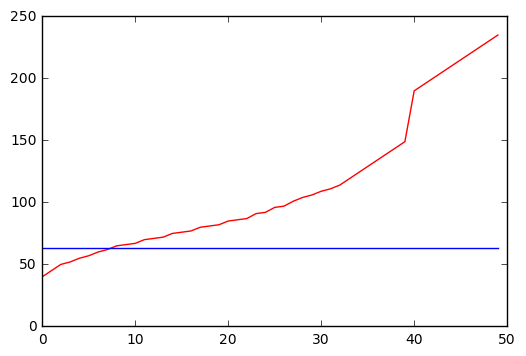

In [65]:
df_result=pd.DataFrame({"real":valid_label.reshape(-1,),"predicted":predicted})
df_predict=df_result["predicted"].groupby(df_result['real']).mean()
err=Error_compute(df_predict.index,df_predict)
print(err)
plt_plot(df_predict.index,df_predict)

In [72]:
df_result["real"].value_counts()

235.0    60
71.0     60
87.0     60
86.0     60
85.0     60
82.0     60
81.0     60
80.0     60
77.0     60
76.0     60
75.0     60
72.0     60
70.0     60
230.0    60
67.0     60
66.0     60
65.0     60
62.0     60
60.0     60
57.0     60
55.0     60
52.0     60
50.0     60
45.0     60
91.0     60
92.0     60
96.0     60
97.0     60
225.0    60
220.0    60
215.0    60
210.0    60
205.0    60
200.0    60
195.0    60
190.0    60
149.0    60
144.0    60
139.0    60
134.0    60
129.0    60
124.0    60
119.0    60
114.0    60
111.0    60
109.0    60
106.0    60
104.0    60
101.0    60
40.0     60
Name: real, dtype: int64